In [30]:
""" Imports """

from collections import namedtuple
import time
import os
import sys
import copy
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from PIL import Image

import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import datasets

from utils import *
from style_subnet import *
from enhance_subnet import *
from refine_subnet import *

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
IMAGE_SIZE = 256
BATCH_SIZE = 1
STYLE_NAME = "picasso"
LR = 1e-3
NUM_EPOCHS = 1
CONTENT_WEIGHTS = [1, 1, 1]
STYLE_WEIGHTS = [2e4, 1e5, 1e3] # Checkpoint single style
#STYLE_WEIGHTS = [5e4, 8e4, 3e4] # Checkpoint two styles
LAMBDAS = [1., 0.5, 0.25]
REG = 1e-7
LOG_INTERVAL = 400

In [32]:
""" Allow PIL to read truncated blocks when loading images """

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [33]:
""" Add a seed to have reproducable results """

SEED = 1080
torch.manual_seed(SEED)

In [34]:
""" Configure training with or without cuda """

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(SEED)
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    kwargs = {'num_workers': 4, 'pin_memory': True}
else:
    device = torch.device("cpu")
    torch.set_default_tensor_type('torch.FloatTensor')
    kwargs = {}

In [35]:
""" Load coco dataset """

# print("Loading dataset..")
# scriptDir = os.path.dirname(os.path.realpath('__file__'))
# DATASET = scriptDir + "/../coco"
# transform = transforms.Compose([transforms.Resize(IMAGE_SIZE),
#                                 transforms.CenterCrop(IMAGE_SIZE),
#                                 transforms.ToTensor(), tensor_normalizer()])
# # http://pytorch.org/docs/master/torchvision/datasets.html#imagefolder
# train_dataset = datasets.ImageFolder(DATASET, transform)
# # http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, **kwargs)

import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pycocotools.coco import COCO
import requests
from PIL import Image
from io import BytesIO

class COCOFromURLDataset(Dataset):
    def __init__(self, annotation_file, transform=None):
        """Initialize the COCO dataset loader
        Args:
            annotation_file (string): Path to the json file with COCO annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.coco = COCO(annotation_file)
        self.transform = transform
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        coco_annotation = coco.loadAnns(ann_ids)
        img_info = coco.loadImgs(img_id)[0]

        # Download image
        img_url = img_info['coco_url']
        response = requests.get(img_url)
        img = Image.open(BytesIO(response.content)).convert('RGB')

        if self.transform:
            img = self.transform(img)

        # Here, we return the image and its ID. You can also return annotations.
        return img, img_id

transform = transforms.Compose([transforms.Resize(IMAGE_SIZE),
                                transforms.CenterCrop(IMAGE_SIZE),
                                transforms.ToTensor(), tensor_normalizer()])
# Initialize your dataset
annotation_file = '/h/u14/c9/00/zhaoha36/Desktop/CSC413/csc413_project/annotations/instances_train2014.json'
train_dataset = COCOFromURLDataset(annotation_file=annotation_file, transform=transform)

# Initialize DataLoader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

loading annotations into memory...
Done (t=7.81s)
creating index...
index created!


In [36]:
""" Load Style Image """

style_img_256, style_img_512, style_img_1024 = style_loader(
    "styles/" + STYLE_NAME + ".jpg", device, [256, 512, 1024])

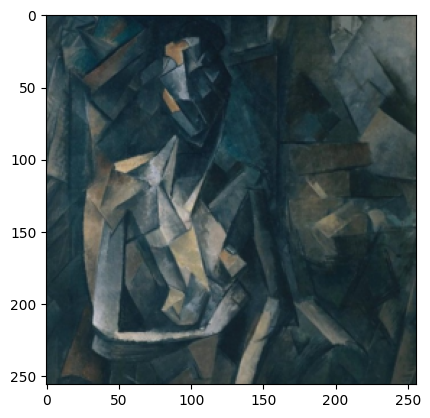

In [37]:
imshow(style_img_256)

In [38]:
""" Define Loss Network """

StyleOutput = namedtuple("StyleOutput", ["relu1_1", "relu2_1", "relu3_1", "relu4_1"])
ContentOutput = namedtuple("ContentOutput", ["relu2_1"])

# https://discuss.pytorch.org/t/how-to-extract-features-of-an-image-from-a-trained-model/119/3
class LossNetwork(torch.nn.Module):
    def __init__(self, vgg):
        super(LossNetwork, self).__init__()
        self.vgg = vgg
        self.layer_name_mapping = {
            '1': "relu1_1", '3': "relu1_2",
            '6': "relu2_1", '8': "relu2_2",
            '11': "relu3_1", '13': "relu3_2", '15': "relu3_3", '17': "relu3_4",
            '20': "relu4_1", '22': "relu4_2", '24': "relu4_3", '26': "relu4_4",
            '29': "relu5_1", '31': "relu5_2", '33': "relu5_3", '35': "relu5_4"
        }

    def forward(self, x, mode):
        if mode == 'style':
            layers = ['1', '6', '11', '20']
        elif mode == 'content':
            layers = ['6']
        else:
            print("Invalid mode. Select between 'style' and 'content'")
        output = {}
        for name, module in self.vgg._modules.items():
            x = module(x)
            if name in layers:
                output[self.layer_name_mapping[name]] = x
        if mode == 'style':
            return StyleOutput(**output)
        else:
            return ContentOutput(**output)

In [39]:
""" Load and extract features from VGG16 """

print("Loading VGG..")
vgg = models.vgg19(pretrained=True).features.to(device).eval()
loss_network = LossNetwork(vgg).to(device).eval()
del vgg

Loading VGG..


In [40]:
""" Before training, compute the features of every resolution of the style image """

print("Computing style features..")
with torch.no_grad(): 
    style_loss_features_256 = loss_network(Variable(style_img_256), 'style')
    style_loss_features_512 = loss_network(Variable(style_img_512), 'style')
    style_loss_features_1024 = loss_network(Variable(style_img_1024), 'style')
gram_style_256 = [Variable(gram_matrix(y).data, requires_grad=False) for y in style_loss_features_256]
gram_style_512 = [Variable(gram_matrix(y).data, requires_grad=False) for y in style_loss_features_512]
gram_style_1024 = [Variable(gram_matrix(y).data, requires_grad=False) for y in style_loss_features_1024]

Computing style features..


In [41]:
""" Init Net and loss """

style_subnet = StyleSubnet().to(device)
enhance_subnet = EnhanceSubnet().to(device)
refine_subnet = RefineSubnet().to(device)

In [42]:
""" Prepare Training """

max_iterations = min(10000, len(train_dataset))

# init loss
mse_loss = torch.nn.MSELoss()
# init optimizer
optimizer = torch.optim.Adam(list(style_subnet.parameters()) + 
                             list(enhance_subnet.parameters()) +
                             list(refine_subnet.parameters()), lr=LR)

def getLosses(generated_img, resized_input_img, content_weight, style_weight, mse_loss, gram_style):
    
    # Compute features
    generated_style_features = loss_network(generated_img, 'style')
    generated_content_features = loss_network(generated_img, 'content')
    target_content_features = loss_network(resized_input_img, 'content')
    
    # Content loss
    target_content_features = Variable(target_content_features[0].data, requires_grad=False)
    content_loss = content_weight * mse_loss(generated_content_features[0], target_content_features)
    
    # Style loss
    style_loss = 0.
    for m in range(len(generated_style_features)):
        gram_s = gram_style[m]
        gram_y = gram_matrix(generated_style_features[m])
        style_loss += style_weight * mse_loss(gram_y, gram_s.expand_as(gram_y))
    
    # Regularization loss
    reg_loss = REG * (
        torch.sum(torch.abs(generated_img[:, :, :, :-1] - generated_img[:, :, :, 1:])) + 
        torch.sum(torch.abs(generated_img[:, :, :-1, :] - generated_img[:, :, 1:, :])))
    
    return content_loss, style_loss, reg_loss

In [48]:
""" Perform Training """

style_subnet.train()
enhance_subnet.train()
refine_subnet.train()
start = time.time()
print("Start training on {}...".format(device))
for epoch in range(NUM_EPOCHS):
    agg_content_loss, agg_style_loss, agg_reg_loss = 0., 0., 0.
    log_counter = 0
    for i, (x, _) in enumerate(train_loader):
        
        
        # update learning rate every 2000 iterations
        if i % 2000 == 0 and i != 0:
            LR = LR * 0.8
            optimizer = torch.optim.Adam(list(style_subnet.parameters()) + 
                                         list(enhance_subnet.parameters()) +
                                         list(refine_subnet.parameters()), lr=LR)
        
        
        optimizer.zero_grad()
        x_in = x.clone()
        
        """ Style Subnet """
        x_in = Variable(x_in).to(device)

        # Generate image
        generated_img_256, resized_input_img_256 = style_subnet(x_in)
        resized_input_img_256 = Variable(resized_input_img_256.data)
        
        # Compute Losses
        style_subnet_content_loss, style_subnet_style_loss, style_subnet_reg_loss = getLosses(
            generated_img_256,
            resized_input_img_256,
            CONTENT_WEIGHTS[0],
            STYLE_WEIGHTS[0],
            mse_loss, gram_style_256)
        
        """ Enhance Subnet """
        x_in = Variable(generated_img_256)
        
        # Generate image
        generated_img_512, resized_input_img_512 = enhance_subnet(x_in)
        resized_input_img_512 = Variable(resized_input_img_512.data)
        
        # Compute Losses
        enhance_subnet_content_loss, enhance_subnet_style_loss, enhance_subnet_reg_loss = getLosses(
            generated_img_512,
            resized_input_img_512,
            CONTENT_WEIGHTS[1],
            STYLE_WEIGHTS[1],
            mse_loss, gram_style_512)

        """ Refine Subnet """
        x_in = Variable(generated_img_512)
        
        # Generate image
        generated_img_1024, resized_input_img_1024 = refine_subnet(x_in)
        resized_input_img_1024 = Variable(resized_input_img_1024.data)
        
        # Compute Losses
        refine_subnet_content_loss, refine_subnet_style_loss, refine_subnet_reg_loss = getLosses(
            generated_img_1024,
            resized_input_img_1024,
            CONTENT_WEIGHTS[2],
            STYLE_WEIGHTS[2],
            mse_loss, gram_style_1024)
        
        # Total loss
        total_loss = LAMBDAS[0] * (style_subnet_content_loss + style_subnet_style_loss + style_subnet_reg_loss) + \
                     LAMBDAS[1] * (enhance_subnet_content_loss + enhance_subnet_style_loss + enhance_subnet_reg_loss) + \
                     LAMBDAS[2] * (refine_subnet_content_loss + refine_subnet_style_loss + refine_subnet_reg_loss)
        total_loss.backward()
        optimizer.step()

        # Aggregated loss
        agg_content_loss += style_subnet_content_loss.item() + \
                            enhance_subnet_content_loss.item() + \
                            refine_subnet_content_loss.item()
        agg_style_loss += style_subnet_style_loss.item() + \
                          enhance_subnet_style_loss.item() + \
                          refine_subnet_style_loss.item()
        
        agg_reg_loss += style_subnet_reg_loss.item() + \
                        enhance_subnet_reg_loss.item() + \
                        refine_subnet_reg_loss.item()
        
        
        # log training process
        if (i + 1) % LOG_INTERVAL == 0:
            log_counter += 1
            hlp = log_counter * LOG_INTERVAL
            time_per_pass = (time.time() - start) / hlp
            estimated_time_left = (time_per_pass * (max_iterations - i))/3600
            print("{} [{}/{}] time per pass: {:.2f}s  total time: {:.2f}s  estimated time left: {:.2f}h  content: {:.6f}  style: {:.6f}  reg: {:.6f}  total: {:.6f}".format(
                        time.ctime(), i+1, max_iterations,
                        (time.time() - start) / hlp,
                        time.time() - start,
                        estimated_time_left,
                        agg_content_loss / LOG_INTERVAL,
                        agg_style_loss / LOG_INTERVAL,
                        agg_reg_loss / LOG_INTERVAL,
                        (agg_content_loss + agg_style_loss + agg_reg_loss) / LOG_INTERVAL))
            agg_content_loss, agg_style_loss, agg_reg_loss = 0., 0., 0.
            imshow(x, title="input image")
            imshow(generated_img_256, title="generated_img_256")
            imshow(generated_img_512, title="generated_img_512")
            imshow(generated_img_1024, title="generated_img_1024")

        """
        if (i + 1) % (10 * LOG_INTERVAL) == 0:
            save_image(generated_img_256, title="log_data/256_iteration_{}_of_{}".format(i+1, max_iterations))
            save_image(generated_img_512, title="log_data/512_iteration_{}_of_{}".format(i+1, max_iterations))
            save_image(generated_img_1024, title="log_data/1024_iteration_{}_of_{}".format(i+1, max_iterations))
            torch.save(style_subnet, 'log_data/trained_style_subnet_it_{}_of_{}.pt'.format(i+1, max_iterations))
            torch.save(enhance_subnet, 'log_data/trained_enhance_subnet_it_{}_of_{}.pt'.format(i+1, max_iterations))
            torch.save(refine_subnet, 'log_data/trained_refine_subnet_it_{}_of_{}.pt'.format(i+1, max_iterations))
            print("Images and models saved in /log_one_data")
        """

        # Stop training after max iterations
        if (i + 1) == max_iterations: break

""" Save model """
torch.save(style_subnet, 'models/trained_style_subnet.pt')
torch.save(enhance_subnet, 'models/trained_enhance_subnet.pt')
torch.save(refine_subnet, 'models/trained_refine_subnet.pt')

Start training on cpu...
tensor(0.0546, grad_fn=<MulBackward0>)
tensor(0.0315, grad_fn=<MulBackward0>)
tensor(0.0143, grad_fn=<MulBackward0>)
tensor(0.0058, grad_fn=<MulBackward0>)
tensor(0.0045, grad_fn=<MulBackward0>)
tensor(0.0028, grad_fn=<MulBackward0>)
tensor(0.0017, grad_fn=<MulBackward0>)
tensor(0.0016, grad_fn=<MulBackward0>)
tensor(0.0018, grad_fn=<MulBackward0>)
tensor(0.0025, grad_fn=<MulBackward0>)
tensor(0.0022, grad_fn=<MulBackward0>)
tensor(0.0022, grad_fn=<MulBackward0>)
tensor(0.0013, grad_fn=<MulBackward0>)
tensor(0.0022, grad_fn=<MulBackward0>)
tensor(0.0018, grad_fn=<MulBackward0>)
tensor(0.0024, grad_fn=<MulBackward0>)
tensor(0.0021, grad_fn=<MulBackward0>)
tensor(0.0027, grad_fn=<MulBackward0>)
tensor(0.0025, grad_fn=<MulBackward0>)
tensor(0.0013, grad_fn=<MulBackward0>)
tensor(0.0023, grad_fn=<MulBackward0>)
tensor(0.0046, grad_fn=<MulBackward0>)
tensor(0.0017, grad_fn=<MulBackward0>)
tensor(0.0056, grad_fn=<MulBackward0>)
tensor(0.0042, grad_fn=<MulBackward0>)
